# Clean Text Data

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

In [ ]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)

In [ ]:
#if IN_COLAB:
  # Uninstall existing versions:
  #!pip uninstall numpy -y
  #!pip uninstall pandas -y
  #!pip uninstall tqdm -y
  #!pip uninstall torch -y
  #!pip uninstall scikit-plot -y
  #!pip uninstall transformers -y
  
  # Install packages:
  #!pip install numpy==1.16.4
  #!pip install pandas
  #!pip install torch==1.4.0
  #!pip install tqdm==4.43.0
  #!pip install scikit-plot
  #!pip install transformers

In [ ]:
import pprint
pprint.pprint(sys.path)

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [ ]:
if IN_COLAB:
  employment_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = '/content/drive/My Drive/Colab Notebooks/proj2/src/data/models/'
else:
  employment_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Employment/'
  cpi_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/CPI/'
  fed_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FEDRates/'
  fx_rates_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/FXRates/'
  gdp_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/GDP/'
  ism_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/ISM/'
  sales_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Sales/'
  treasury_data_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/MarketData/Treasury/'
  fomc_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/FOMC/'
  preprocessed_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/preprocessed/'
  train_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/train_data/'
  output_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/result/'
  keyword_lm_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/LoughranMcDonald/'
  glove_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/GloVe/'
  model_dir = 'C:/Users/theon/GDrive/Colab Notebooks/proj2/src/data/models/'

In [ ]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [ ]:
# Functions for map() or apply()

def get_word_count(x):
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
            print(type(x))
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar['date'].iloc[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar['date'].iloc[i]:
                return fomc_calendar['date'].iloc[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strftime(x, '%Y-%m-%d')
            print(type(x))
        except:
            return None
    
    chairperson = chairpersons.loc[chairpersons['FromDate'] <= x].loc[x <= chairpersons['ToDate']]
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [ ]:
def reorganize_df(df, doc_type):
    if doc_type in ('statement', 'minutes', 'press_conference', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [ ]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    print(split_df)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [ ]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [ ]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

### Load Calendar

In [ ]:
file = open(fomc_dir + 'fomc_calendar.pickle', 'rb')
fomc_calendar = pickle.load(file)
file.close()

print(type(fomc_calendar))
fomc_calendar

In [ ]:
# #Check calendar
#fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1998, 1, 27)]

### Statement

In [ ]:
file = open(fomc_dir + 'statement.pickle', 'rb')
statement_df = pickle.load(file)
file.close()

In [ ]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

### Meeting Minutes

In [ ]:
file = open(fomc_dir + 'minutes.pickle', 'rb')
minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

In [ ]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

### Meeting Transcripts

In [ ]:
file = open(fomc_dir + 'meeting_script.pickle', 'rb')
meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

In [ ]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

### Press Conference Transcripts

In [ ]:
file = open(fomc_dir + 'press_conference.pickle', 'rb')
presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

In [ ]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

### Speech

In [ ]:
file = open(fomc_dir + 'speech.pickle', 'rb')
speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

In [ ]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

### Testimony

In [ ]:
file = open(fomc_dir + 'testimony.pickle', 'rb')
testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

In [ ]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

## Statements DataFrame

In [ ]:
statement_df.head()

### Add Quantitative Easing as a Lower event

In [ ]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."
    statement_df = statement_df.append(
        pd.Series([dt.datetime.strptime('2008-11-25', '%Y-%m-%d'), qe_text, 'Ben Bernanke', 'FOMC statement'], index=statement_df.columns),
        ignore_index=True
    )
    

### Process the dataframe

In [ ]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

In [ ]:
# Check the returned dataframe
proc_statement_df

In [ ]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

In [ ]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar['date'].iloc[:] > x]

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [ ]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df

In [ ]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [ ]:
minutes_df.head()

In [ ]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

In [ ]:
# Check the returned dataframe
proc_minutes_df

In [ ]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [ ]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [ ]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

In [ ]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [ ]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [ ]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df

In [ ]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [ ]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [ ]:
# Sample
print(presconf_script_df['contents'][2])

In [ ]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'press_conference')


In [ ]:
# Check the returned dataframe
proc_presconf_script_df

In [ ]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [ ]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

In [ ]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

In [ ]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [ ]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
presconf_script_chair_df

In [ ]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

In [ ]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [ ]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [ ]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df

In [ ]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [ ]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [ ]:
meeting_script_df.head()

In [67]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')

1980-01-11 00:00:00
1980-02-05 00:00:00
1980-02-07 00:00:00
1980-02-22 00:00:00
1980-03-20 00:00:00
1980-04-22 00:00:00
1980-04-24 00:00:00
1980-04-29 00:00:00
1980-05-22 00:00:00
1980-06-05 00:00:00
1980-07-11 00:00:00
1980-07-25 00:00:00
1980-08-14 00:00:00
1980-08-22 00:00:00
1980-09-18 00:00:00
1980-10-21 00:00:00
1980-10-23 00:00:00
1980-11-18 00:00:00
1980-12-21 00:00:00
1981-02-03 00:00:00
1981-02-05 00:00:00
1981-02-24 00:00:00
1981-04-02 00:00:00
1981-04-28 00:00:00
1981-05-20 00:00:00
1981-06-17 00:00:00
1981-07-09 00:00:00
1981-07-17 00:00:00
1981-08-20 00:00:00
1981-10-06 00:00:00
1981-10-08 00:00:00
1981-11-17 00:00:00
1981-11-19 00:00:00
1981-12-22 00:00:00
1981-12-24 00:00:00
1982-02-02 00:00:00
1982-02-04 00:00:00
1982-03-30 00:00:00
1982-04-01 00:00:00
1982-05-18 00:00:00
1982-05-20 00:00:00
1982-06-01 00:00:00
1982-07-03 00:00:00
1982-07-15 00:00:00
1982-08-26 00:00:00
1982-09-24 00:00:00
1982-10-07 00:00:00
1982-11-16 00:00:00
1982-11-18 00:00:00
1982-12-21 00:00:00


In [68]:
# Sample
print(meeting_script_df['contents'][2])

--and we need a nomination.

[SECTION]

of the FOMC!

[SECTION]

CHAIRMAN VOLCKER.

[SECTION]

MR. PARTEE.

[SECTION]



[SECTION]

that way!

[SECTION]



[SECTION]

Chairman.

[SECTION]

Vice Chairman of the FOMC.

[SECTION]

date. Is there a second?

[SECTION]



[SECTION]

the nominees.

[SECTION]

That's the list, Mr. Chairman.

[SECTION]

plenitude of Davises--pardon me?

[SECTION]



[SECTION]

motion to that effect?

[SECTION]



[SECTION]

[reappointment them]?

[SECTION]



[SECTION]

have a motion?

[SECTION]



[SECTION]

CHAIRMAN VOLCKER.

[SECTION]



[SECTION]

since the last meeting, Mr. Pardee.

[SECTION]



[SECTION]

price of gold. Would that include any major commercial banks?

[SECTION]

past from the U.S. Treasury.

[SECTION]



[SECTION]

they can withstand such losses.

[SECTION]

dollar to go up in the face of that?

[SECTION]

bearish.

[SECTION]

of that?

[SECTION]

amounts.

[SECTION]

absence of intervention.

[SECTION]

[the dollar] has been pretty steady

In [69]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...","[CHAIR YELLEN. I’d like to 

In [70]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45039,<NA>,None,1980-02-05,<NA>,None,MR. STERNLIGHT.[SECTION]CHAIRMAN VOLCKER.securities] since when?[SECTION]MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79.[SECTION]CHAIRMA...,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39604,<NA>,None,1980-02-22,<NA>,None,CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe ...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. Weare not in a meeting at this point anyway; we may be in a meetinglater. I would just remind all of you that I sent out a memorandum onthe...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We\rare not in a meeting at this point anyway; we may be in a meeting\rlater. I would just remind all of you that I sent out a memorandum on...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,23954,<NA>,None,1980-04-22,<NA>,None,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We havethe...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemenand lady. We have a lot of business to dispose of at the start and Iwill try to find my agenda, if you will excuse me a moment. We haveth...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen\rand lady. We have a lot of business to dispose of at the start and I\rwill try to find my agenda, if you will excuse me a moment. We hav..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21170,<NA>,None,1980-04-29,<NA>,None,"CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your fi...","[CHAIRMAN VOLCKER.Can we come to order, ladies andgentlemen?I am delighted to say that our Vice Chairman, Mr. Solomon,who was duly elected in absentia last time, is with us today. Welcometo your f...","CHAIRMAN VOLCKER.\rCan we come to order, ladies and\rgentlemen?\rI am delighted to say that our Vice Chairman, Mr. Solomon,\rwho was duly elected in absentia last time, is with us today. Welcome\r..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24276,<NA>,None,1980-06-05,<NA>,None,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes.[SECTION]MR. SCHULTZ.So moved.[SECTION]CHAIRMAN VOLCKER.[SECTION]MS. TEETERS.WeDo we have a second?Second.[SECTIO...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.need to approve the minutes., MR. SCHULTZ.So moved., CHAIRMAN VOLCKER., MS. TEETERS.WeDo we have a second?Second., CHAIRMAN VOLCKER. Without...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen.\rneed to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ.\r\rSo moved.\r\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\r\n\n[SECTION]\n\nMS. TEETER..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88988,<NA>,None,2014-07-30,<NA>,None,"CHAIR YELLEN. I’d like to begin by welcoming three people to the table today: StanFischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan andLael, but both have ve...","[CHAIR YELLEN. I’d like to 

(282, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


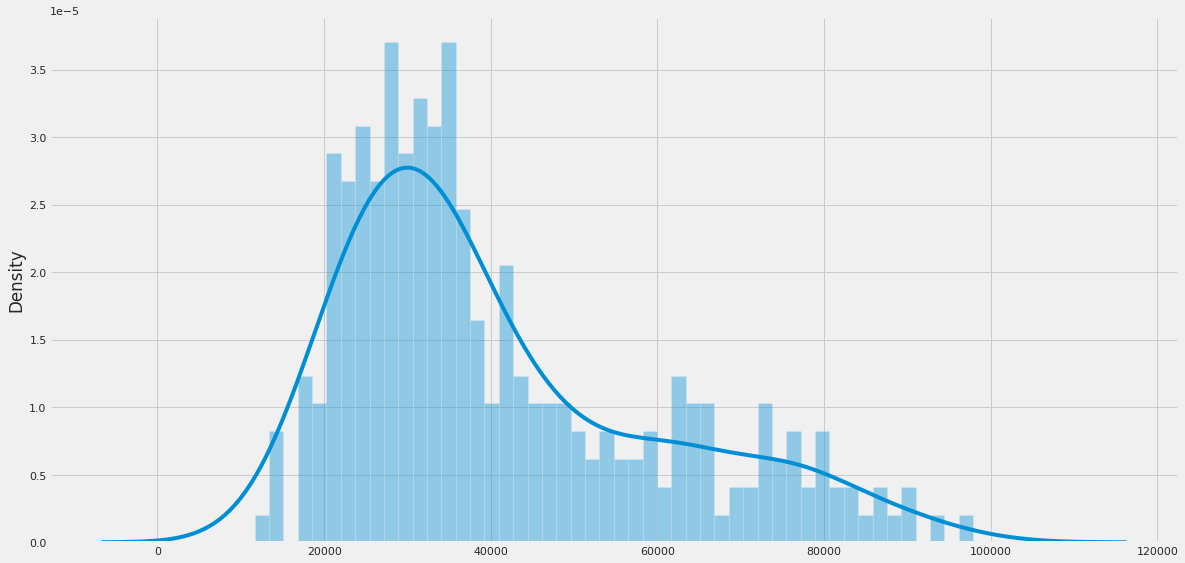

In [71]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [72]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

Streaming output truncated to the last 5000 lines.

not matched:  MR. HOENIG.Thank you.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.The inflation blip but not the nominal GDPblip?
1994-07-06 00:00:00

not matched:  MR. KOHN.I call on Mr. Kohn.[Statement--See Appendix.]
1994-07-06 00:00:00

not matched:  MR. KOHN.I think the models embody a vertical long-runPhillips curve; it takes a while for it to come out here.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Into the next millennium!If you had not noticed that the inflation
1994-07-06 00:00:00

not matched:  MR. KOHN.But never backwards?No.Only the coefficient is unchanged even
1994-07-06 00:00:00

not matched:  MR. KOHN.stretched out--In this time period, that's right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.No, go ahead, please finish.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.Right.
1994-07-06 00:00:00

not matched:  MR. LINDSEY.And when will we ever pay the price?
1994-07-06 00:00:00

not matched:  MR. LINDSEY.But t

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMA,4,<NA>,None,1980-02-05,<NA>,None,VOLCKER.securities] since when?,"[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,25,<NA>,None,1980-02-05,<NA>,None,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1205,<NA>,None,1980-02-05,<NA>,None,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,31,<NA>,None,1980-02-05,<NA>,None,"I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. PARTEE,107,<NA>,None,1980-02-05,<NA>,None,"Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...","[MR. STERNLIGHT., CHAIRMAN VOLCKER.securities] since when?, MR. STERNLIGHT.[Statement--see Appendix.][That was the change in System holdings ofThat was for all of '79., CHAIRMAN VOLCKER. Steve, if...",MR. STERNLIGHT.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER.\rsecurities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT.\r\r[Statement--see Appendix.]\r[That was the change in System holdings of\rThat was f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88214,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,79,<NA>,None,2015-01-28,<NA>,None,"Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The firstitem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to closethe Board meeting., ...","CHAIR YELLEN. Good afternoon, everyone. I think

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [73]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88219, 13)
After:  (47498, 13)


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


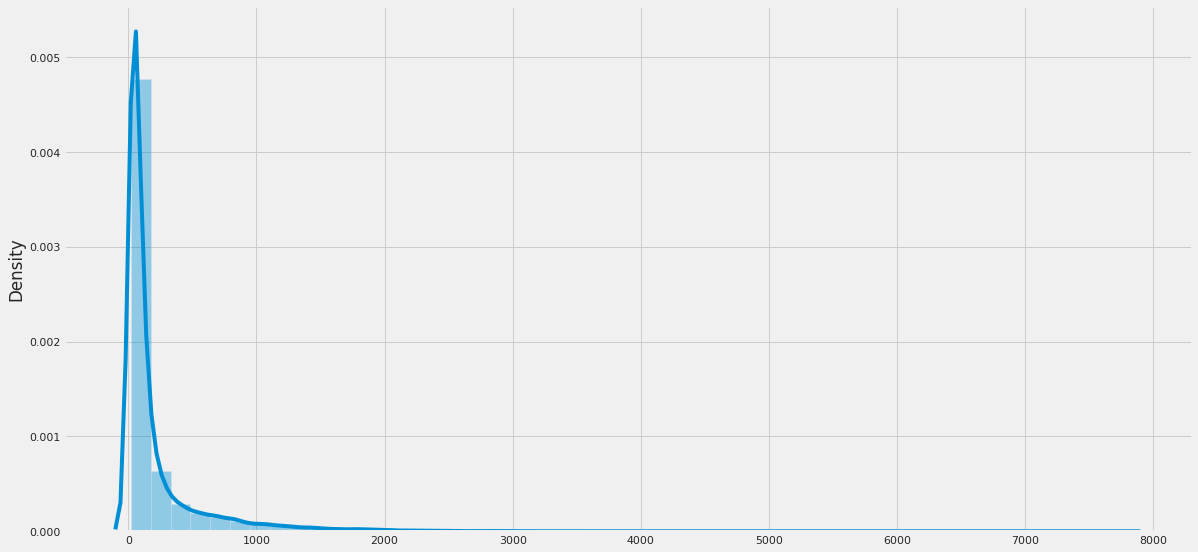

In [74]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [75]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df

,index,text,text_sections,word_count
0,1,"Steve, if you want to add something thatbears upon the nature of the operations, this is probably as good atime as any to do it.","[S, t, e, v, e, ,, , i, f, , y, o, u, , w, a, n, t, , t, o, , a, d, d, , s, o, m, e, t, h, i, n, g, , t, h, a, t, b, e, a, r, s, , u, p, o, n, ...]",25
1,2,"Mr. Chairman, we have some tables we could passout, which are somewhat similar to the ones that we made available tothe Committee at the last meeting and which might be helpful inconsidering how a...","[M, r, ., , C, h, a, i, r, m, a, n, ,, , w, e, , h, a, v, e, , s, o, m, e, , t, a, b, l, e, s, , w, e, , c, o, u, l, d, , p, a, s, s, o, u, t, ...]",1205
2,3,"I'm sure that's crystal clear!So, Ithink it's time to raise questions--not just on the details of Peter'soperations, but questions that bear upon the operating techniquesgenerally. Governor Partee.","[I, ', m, , s, u, r, e, , t, h, a, t, ', s, , c, r, y, s, t, a, l, , c, l, e, a, r, !, S, o, ,, , I, t, h, i, n, k, , i, t, ', s, , t, i, m, e, ...]",31
3,4,"Well, just a comment. I think I understood thedirection of your adjustments, Steve, as you went through this. But Icertainly don't understand it from this table on the second page. Ican't make out...","[W, e, l, l, ,, , j, u, s, t, , a, , c, o, m, m, e, n, t, ., , I, , t, h, i, n, k, , I, , u, n, d, e, r, s, t, o, o, d, , t, h, e, d, i, r, e, ...]",107
4,6,"Well, one of the things that is disturbing me-about the whole period really but particularly the last month or so-is that we don't seem to be getting any market impact. We have tohave feed-through...","[W, e, l, l, ,, , o, n, e, , o, f, , t, h, e, , t, h, i, n, g, s, , t, h, a, t, , i, s, , d, i, s, t, u, r, b, i, n, g, , m, e, -, a, b, o, u, ...]",131
...,...,...,...,...
47493,88209,"Thank you. Since we last met, we have seen two strong payrollreports, and the labor market is clearly continuing to strengthen, which is very welcome. But, ofcourse, we also see continued risks as...","[T, h, a, n, k, , y, o, u, ., , S, i, n, c, e, , w, e, , l, a, s, t, , m, e, t, ,, , w, e, , h, a, v, e, , s, e, e, n, , t, w, o, , s, t, r, ...]",480
47494,88213,"No worries. It happened one time under ChairmanBernanke’s watch, too. So you can do it once. [Laughter.] I support alternative B, and I am December 16–17, 2014170 of 219comfortable with what the C...","[N, o, , w, o, r, r, i, e, s, ., , I, t, , h, a, p, p, e, n, e, d, , o, n, e, , t, i, m, e, , u, n, d, e, r, , C, h, a, i, r, m, a, n, B, e, r, ...]",1412
47495,88214,"Thank you. Okay. I think the main open issue in the statement is thebracketed word “somewhat” in paragraph 1, and I heard one, two, three, four, five, six—eightpeople propose removing it. I’m cert...","[T, h, a, n, k, , y, o, u, ., , O, k, a, y, ., , I, , t, h, i, n, k, , t, h, e, , m, a, i, n, , o, p, e, n, , i, s, s, u, e, , i, n, , t, h, ...]",79
47496,88215,"This vote, as Chair Yellen indicated, will be on alternative B, depictedon pages 6 and 7 of Bill English’s handout. It will not have the word “somewhat” on line 3. Itwill also cover the directive ...","[T, h, i, s, , v, o, t, e, ,, , a, s, , C, h, a, i, r, , Y, e, l, l, e, n, , i, n, d, i, c, a, t, e, d, ,, , w, i, l, l, , b, e, , o, n, , a, ...]",47


/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


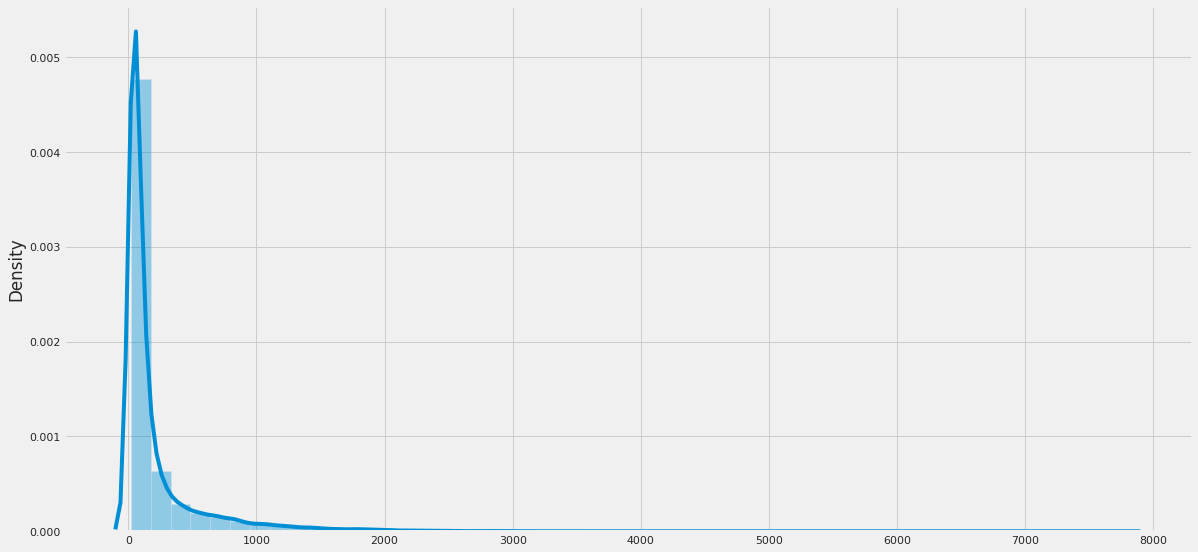

In [76]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [ ]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df

### Filter out by keywords

In [ ]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=False, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df

In [ ]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [ ]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

In [ ]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

In [ ]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df

In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
speech_chair_df

### Split contents to max 200 words

In [ ]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df

In [ ]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [ ]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

In [ ]:
# Check the returned dataframe
proc_testimony_df

In [ ]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [ ]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

In [ ]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

In [ ]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson.lower().split()[-1] in row['speaker'].lower():
        row['speaker'] = chairperson
        tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

### Split contents to max 200 words

In [ ]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df

### Filter out by keyword

In [ ]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df

In [ ]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [ ]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

In [ ]:
def save_data(df, file_name, dir_name=preprocessed_dir):
  if not os.path.exists(dir_name):
    os.mkdir(dir_name)
  # Save results to a picke file
  file = open(dir_name + file_name + '.pickle', 'wb')
  pickle.dump(df, file)
  file.close()
  print("Data Saved to a pickle file in {} !".format(dir_name))
  # Save results to a csv file
  #df.to_csv(dir_name + file_name + '.csv', index=True)
  #print("Data Saved to a csv file in {} !".format(dir_name))

In [ ]:
save_data(text_no_split, 'text_no_split')

In [ ]:
save_data(text_split_200, 'text_split_200')

In [ ]:
save_data(text_keyword, 'text_keyword')